In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.models import load_model
import datetime
from scipy.io import wavfile
from sklearn.preprocessing import StandardScaler
from pydub import AudioSegment
from scipy.signal import resample
import yfinance as yf
import tensorflow as tf

In [2]:
code = '^KS11' #KOSPI Composite Index
kospi = yf.Ticker(code)
kospi = kospi.history(period='20y')
kospi = kospi[['Close']]
print(kospi)

                  Close
Date                   
2001-09-03   541.830017
2001-09-04   558.789978
2001-09-05   551.909973
2001-09-06   552.590027
2001-09-07   555.080017
...                 ...
2021-08-30  3144.189941
2021-08-31  3199.270020
2021-09-01  3207.020020
2021-09-02  3175.850098
2021-09-03  3201.060059

[4938 rows x 1 columns]


In [3]:
# X : 날짜에 따른 순차적인 인덱스
# y : 각 날짜에 따른 코스피 지수의 종가
dates = kospi.Close.index
X = np.arange(len(dates)).reshape(-1,1)
y = kospi.Close.values
y = y.reshape(-1,1)
print("X : \n", X)
print("\ny : \n", y)

X : 
 [[   0]
 [   1]
 [   2]
 ...
 [4935]
 [4936]
 [4937]]

y : 
 [[ 541.83001709]
 [ 558.78997803]
 [ 551.90997314]
 ...
 [3207.02001953]
 [3175.85009766]
 [3201.06005859]]


In [4]:
# 딥러닝 학습을 정상적으로 동작 시키기 위해 데이터 정규화
y_std = y.std()
y_mean = y.mean()
y = (y-y_mean) / y_std

In [5]:
# 현재를 기준으로 최근 10일 데이터를 시험에 사용하고 그 외의 이전 데이터들은 학습에 사용
test_period = 10

X_train = X[:-test_period]
y_train = y[:-test_period]
X_test = X[-test_period:]
y_test = y[-test_period:]

print("shape of X_train : ", X_train.shape)
print("shape of y_train : ", y_train.shape)
print("shape of X_test : ", X_test.shape)
print("shape of y_test : ", y_test.shape)

shape of X_train :  (4928, 1)
shape of y_train :  (4928, 1)
shape of X_test :  (10, 1)
shape of y_test :  (10, 1)


In [6]:
# 학습데이터 : 검증데이터 = 7 : 3  (학습이 진행되는 중에도 학습이 정상적으로 이루어지는지 확인하기 위함)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [7]:
# tensorflow에 데이터를 전달하기 전에 입력 형식을 맞추기 위해 2차원 데이터를 3차원 데이터로 변환
X = X.reshape(-1, 1, 1)
X_train = X_train.reshape(-1, 1, 1)
X_val = X_val.reshape(-1, 1, 1)
X_test = X_test.reshape(-1, 1, 1)

print("shape of X_train : ", X.shape)
print("shape of X_train : ", X_train.shape)
print("shape of X_val : ", X_val.shape)
print("shape of X_test : ", X_test.shape)

shape of X_train :  (4938, 1, 1)
shape of X_train :  (3449, 1, 1)
shape of X_val :  (1479, 1, 1)
shape of X_test :  (10, 1, 1)


In [8]:
# LSTM 모델 생성 
model = Sequential()

model.add(LSTM(8, input_shape=(None,1)))
model.add(Dense(4))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 320       
_________________________________________________________________
dense (Dense)                (None, 4)                 36        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [9]:
hist = model.fit(X_train, y_train, epochs = 15, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/15
108/108 [==============================] - 4s 15ms/step - loss: 0.9761 - val_loss: 0.9673
Epoch 2/15
108/108 [==============================] - 0s 3ms/step - loss: 0.9328 - val_loss: 0.8759
Epoch 3/15
108/108 [==============================] - 0s 2ms/step - loss: 0.7969 - val_loss: 0.5260
Epoch 4/15
108/108 [==============================] - 0s 2ms/step - loss: 0.5978 - val_loss: 0.4092
Epoch 5/15
108/108 [==============================] - 0s 2ms/step - loss: 0.3821 - val_loss: 0.2381
Epoch 6/15
108/108 [==============================] - 0s 2ms/step - loss: 0.2350 - val_loss: 0.1981
Epoch 7/15
108/108 [==============================] - 0s 2ms/step - loss: 0.1953 - val_loss: 0.2069
Epoch 8/15
108/108 [==============================] - 0s 2ms/step - loss: 0.2040 - val_loss: 0.2056
Epoch 9/15
108/108 [==============================] - 0s 2ms/step - loss: 0.1630 - val_loss: 0.1986
Epoch 10/15
108/108 [==============================] - 0s 2ms/step - loss: 0.1912 - val_loss: 0.217

<function matplotlib.pyplot.show(close=None, block=None)>

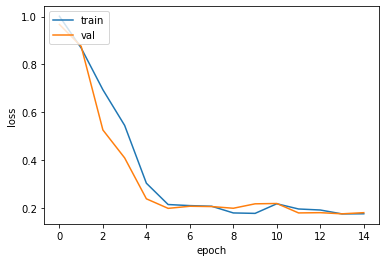

In [10]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show

In [11]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
valScore = model.evaluate(X_val, y_val, verbose=0)
testScore = model.evaluate(X_test, y_test, verbose=0)

print('Train Score : ', trainScore)
print('Validation Score : ', valScore)
print('Test Score : ', testScore)

Train Score :  0.16331249475479126
Validation Score :  0.18014079332351685
Test Score :  2.0059738159179688


<ipython-input-12-abf6d5f0e340>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return dates[x].flatten()
<ipython-input-12-abf6d5f0e340>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return dates[x].flatten()
<ipython-input-12-abf6d5f0e340>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return dates[x].flatten()
<ipython-input-12-abf6d5f0e340>:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return dates[x].flatten()
<ipython-input-12-ab

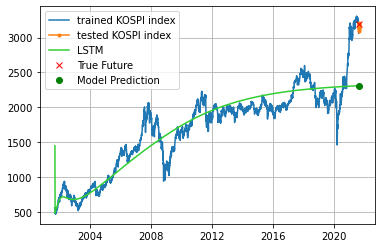

In [12]:
# 이전에 만들었던 인덱스를 통해 날짜를 얻어오기 위해 사용하는 함수
def get_dates(x):
    return dates[x].flatten()

# 정규화된 데이터를 복원하기 위해 사용하는 함수
def denorm(y):
    return y * y_std + y_mean

prediction = model.predict(X.reshape(-1, 1, 1), batch_size = 32)
plt.plot(get_dates(X[:-10]), denorm(y[:-10]), label='trained KOSPI index')
plt.plot(get_dates(X_test), denorm(y_test), '.-', label='tested KOSPI index')
plt.plot(get_dates(X), denorm(prediction), c='limegreen', label='LSTM')

X_last = X[-1:]
y_last = y[-1:]
y_last_prediction = model.predict(X_last.reshape(-1, 1, 1))
plt.plot(get_dates(X_last), denorm(y_last), 'rx', label='True Future')
plt.plot(get_dates(X_last), denorm(y_last_prediction), 'go', label='Model Prediction')

plt.legend()
plt.grid()
plt.show()